# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_nopercolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 10, 10
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['block8_10_conv', 'conv_7b']
    PREPROCESSING = tf.keras.applications.inception_resnet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8237 - accuracy: 0.7288

947/947 [==============================] - 5681s 6s/step - loss: 0.8237 - accuracy: 0.7288 - val_loss: 0.8112 - val_accuracy: 0.7214
Epoch 2/200
947/947 [==============================] - 4819s 5s/step - loss: 0.7263 - accuracy: 0.7517 - val_loss: 0.9796 - val_accuracy: 0.7048
Epoch 3/200
947/947 [==============================] - ETA: 0s - loss: 0.6759 - accuracy: 0.7685

947/947 [==============================] - 5231s 6s/step - loss: 0.6759 - accuracy: 0.7685 - val_loss: 0.7950 - val_accuracy: 0.7354
Epoch 4/200
947/947 [==============================] - ETA: 0s - loss: 0.6239 - accuracy: 0.7816

947/947 [==============================] - 5211s 6s/step - loss: 0.6239 - accuracy: 0.7816 - val_loss: 0.6491 - val_accuracy: 0.7663
Epoch 5/200
947/947 [==============================] - 4828s 5s/step - loss: 0.5939 - accuracy: 0.7918 - val_loss: 1.0615 - val_accuracy: 0.7570
Epoch 6/200
947/947 [==============================] - 4827s 5s/step - loss: 0.5657 - accuracy: 0.8032 - val_loss: 0.6658 - val_accuracy: 0.7786
Epoch 7/200
947/947 [==============================] - 4825s 5s/step - loss: 0.5456 - accuracy: 0.8070 - val_loss: 0.6688 - val_accuracy: 0.7904
Epoch 8/200
947/947 [==============================] - ETA: 0s - loss: 0.5287 - accuracy: 0.8147

947/947 [==============================] - 5243s 6s/step - loss: 0.5287 - accuracy: 0.8147 - val_loss: 0.5340 - val_accuracy: 0.8118
Epoch 9/200
947/947 [==============================] - 4831s 5s/step - loss: 0.5162 - accuracy: 0.8180 - val_loss: 0.5828 - val_accuracy: 0.7936
Epoch 10/200
947/947 [==============================] - 4829s 5s/step - loss: 0.4948 - accuracy: 0.8236 - val_loss: 0.6261 - val_accuracy: 0.7790
Epoch 11/200
947/947 [==============================] - 4832s 5s/step - loss: 0.4759 - accuracy: 0.8314 - val_loss: 0.5655 - val_accuracy: 0.8054
Epoch 12/200
947/947 [==============================] - 4831s 5s/step - loss: 0.4684 - accuracy: 0.8308 - val_loss: 0.6261 - val_accuracy: 0.7822
Epoch 13/200
947/947 [==============================] - 4833s 5s/step - loss: 0.4574 - accuracy: 0.8366 - val_loss: 0.5430 - val_accuracy: 0.8093
Epoch 14/200
947/947 [==============================] - 4828s 5s/step - loss: 0.4360 - accuracy: 0.8415 - val_loss: 0.5647 - val_accuracy:

947/947 [==============================] - 5241s 6s/step - loss: 0.4226 - accuracy: 0.8463 - val_loss: 0.4751 - val_accuracy: 0.8292
Epoch 17/200
947/947 [==============================] - 4836s 5s/step - loss: 0.4309 - accuracy: 0.8466 - val_loss: 0.4967 - val_accuracy: 0.8303
Epoch 18/200
947/947 [==============================] - 4834s 5s/step - loss: 0.3815 - accuracy: 0.8620 - val_loss: 0.4942 - val_accuracy: 0.8140
Epoch 19/200
947/947 [==============================] - 4833s 5s/step - loss: 0.3752 - accuracy: 0.8642 - val_loss: 0.4994 - val_accuracy: 0.8221
Epoch 20/200
947/947 [==============================] - 4833s 5s/step - loss: 0.3636 - accuracy: 0.8680 - val_loss: 0.4890 - val_accuracy: 0.8334
Epoch 21/200
947/947 [==============================] - ETA: 0s - loss: 0.3522 - accuracy: 0.8740

947/947 [==============================] - 5225s 6s/step - loss: 0.3522 - accuracy: 0.8740 - val_loss: 0.4653 - val_accuracy: 0.8356
Epoch 22/200
947/947 [==============================] - 4831s 5s/step - loss: 0.3533 - accuracy: 0.8723 - val_loss: 0.4654 - val_accuracy: 0.8345
Epoch 23/200
947/947 [==============================] - 4833s 5s/step - loss: 0.3319 - accuracy: 0.8805 - val_loss: 0.9149 - val_accuracy: 0.7317
Epoch 24/200
947/947 [==============================] - 4833s 5s/step - loss: 0.3952 - accuracy: 0.8589 - val_loss: 0.5024 - val_accuracy: 0.8290
Epoch 25/200
947/947 [==============================] - 4835s 5s/step - loss: 0.3179 - accuracy: 0.8827 - val_loss: 2884.2007 - val_accuracy: 0.0202
Epoch 26/200
947/947 [==============================] - 4832s 5s/step - loss: 0.3214 - accuracy: 0.8840 - val_loss: 0.4786 - val_accuracy: 0.8400
Epoch 27/200
947/947 [==============================] - ETA: 0s - loss: 0.2976 - accuracy: 0.8898

947/947 [==============================] - 5229s 6s/step - loss: 0.2976 - accuracy: 0.8898 - val_loss: 0.4612 - val_accuracy: 0.8486
Epoch 28/200
947/947 [==============================] - 4832s 5s/step - loss: 0.2836 - accuracy: 0.8959 - val_loss: 0.5022 - val_accuracy: 0.8295
Epoch 29/200
947/947 [==============================] - 4832s 5s/step - loss: 0.2724 - accuracy: 0.8994 - val_loss: 0.4835 - val_accuracy: 0.8370
Epoch 30/200
947/947 [==============================] - 4934s 5s/step - loss: 0.2724 - accuracy: 0.9003 - val_loss: 0.6458 - val_accuracy: 0.8144
Epoch 31/200
947/947 [==============================] - 4921s 5s/step - loss: 0.2556 - accuracy: 0.9059 - val_loss: 0.9191 - val_accuracy: 0.7562
Epoch 32/200
947/947 [==============================] - 4918s 5s/step - loss: 0.2795 - accuracy: 0.8969 - val_loss: 0.4914 - val_accuracy: 0.8414
Epoch 33/200
947/947 [==============================] - 4917s 5s/step - loss: 0.2328 - accuracy: 0.9139 - val_loss: 0.4875 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 574s 3s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9669843291692473,
 'basal cell carcinoma': 0.9885573315678299,
 'dermatofibroma': 0.9860048609450953,
 'melanoma': 0.9356942765730537,
 'nevus': 0.9650775300626774,
 'pigmented benign keratosis': 0.9812125316677954,
 'seborrheic keratosis': 0.9542316038666404,
 'solar lentigo': 0.9645658682634731,
 'squamous cell carcinoma': 0.9836157231511695,
 'vascular lesion': 0.9986946908548443}

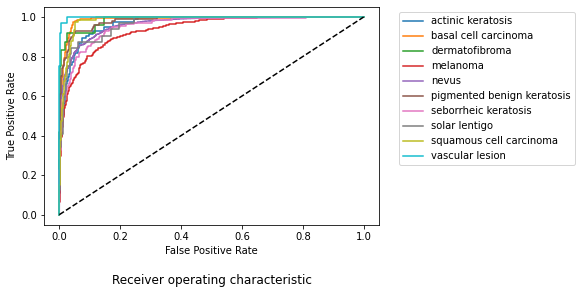

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

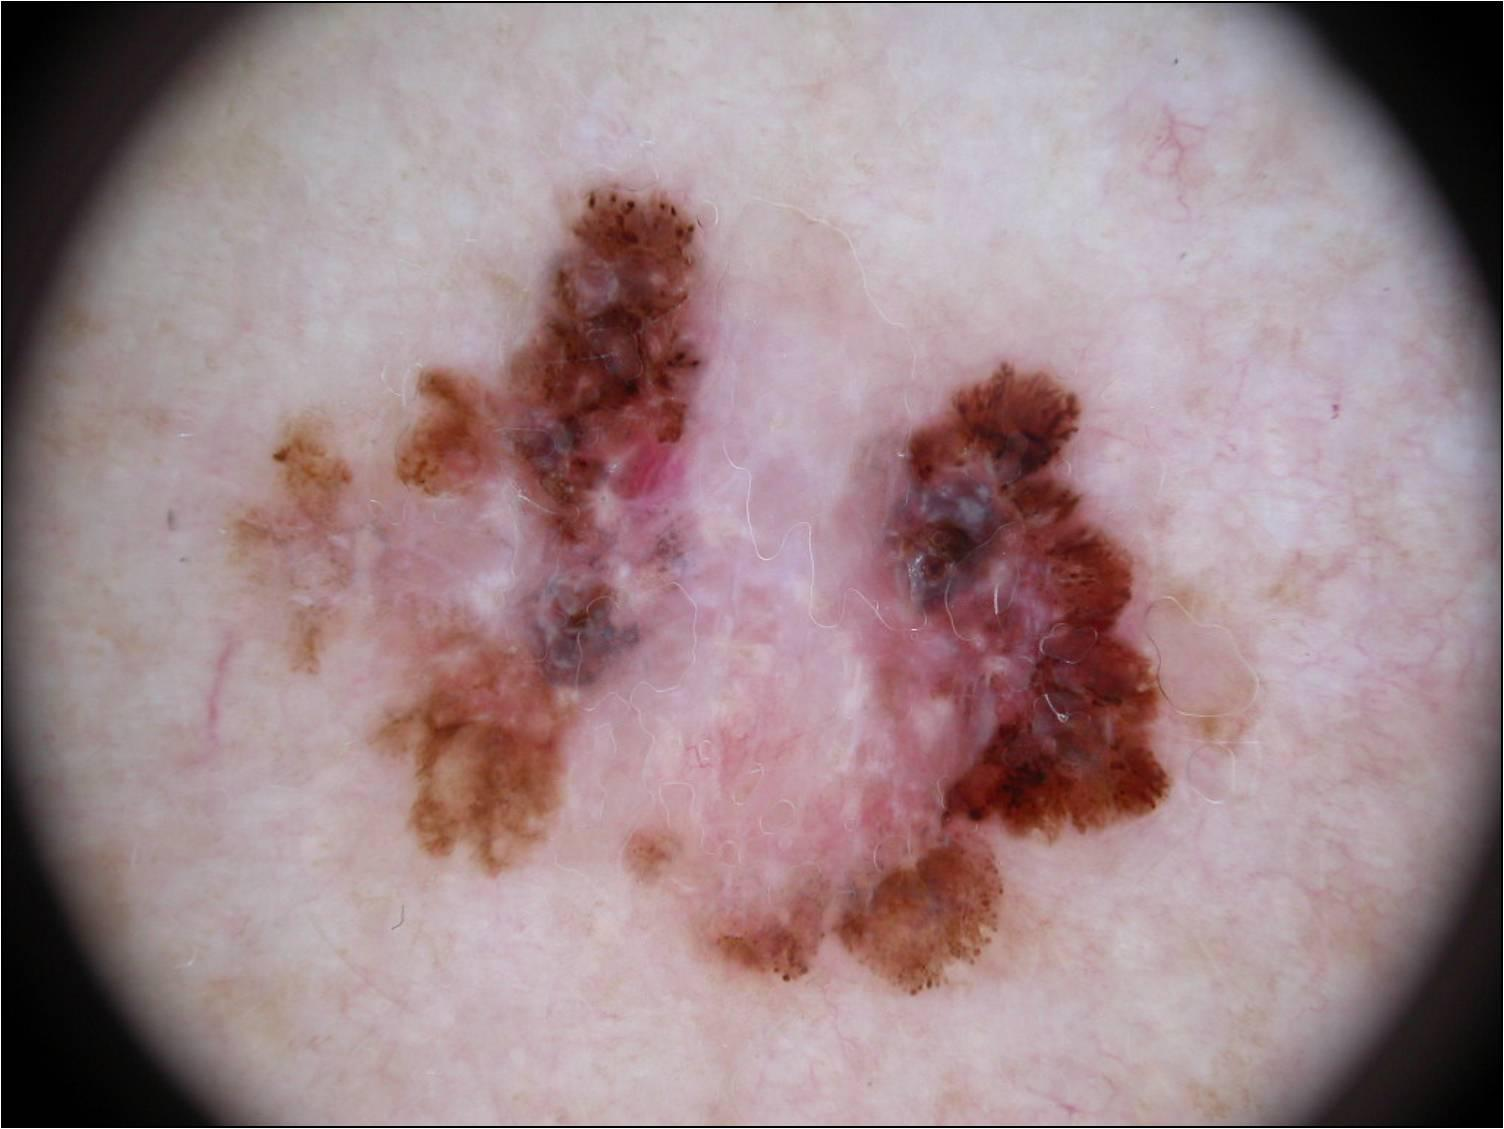

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, 'conv_7b')

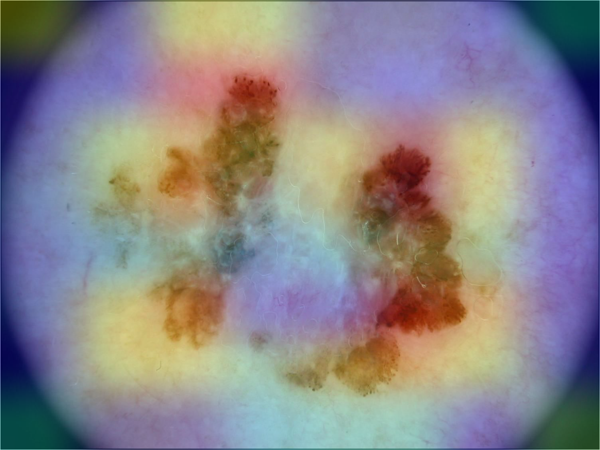

In [23]:
display_gradcam(melanoma_im_path, heatmap)